# Setup

In [1]:
import os
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'w'
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
import sys

# Load data

In [2]:
comparison_folder = os.path.join(os.path.dirname(os.getcwd()),'data', 'BF_approximation_comparison')
bridge_file = '2021_11_16___20_08_BF_approx_comp'
NN_fixed_file = '2022_03_18___17_06_BF_NN_comp'
NN_variable_file = '2022_01_17___17_10_BF_NN_variable_comp'

bridge = pd.read_csv(os.path.join(comparison_folder, bridge_file), sep = " ").reset_index(drop=True)
NN_fixed = pd.read_csv(os.path.join(comparison_folder, NN_fixed_file))
NN_variable = pd.read_csv(os.path.join(comparison_folder, NN_variable_file))

In [3]:
#bridge.head()

In [4]:
#NN_fixed.head()

In [5]:
#NN_variable.head()

# Calculate performance metrics

In [6]:
def performance_metrics(bridge_sampling_results, NN_fixed_results, NN_variable_results, names):
    """ Calculates various metrics to compare approximation performance.

    Parameters
    ----------
    bridge_sampling_results : np.array
        Bridge Sampling approximations
    NN_fixed_results : np.array
        Neural network (trained on fixed sample sizes) approximations
    NN_variable_results : np.array
        Neural network (trained on varying sample sizes) approximations
    names : list
        Method names

    Returns
    -------
    df : pd.DataFrame
        Table with calculated performance metrics
    """
    
    mae = []
    rmse = []
    roc_auc = [] 
    accuracy = []
    
    for d in (bridge_sampling_results, NN_fixed_results, NN_variable_results):
        mae_temp = np.mean(abs(d['true_model']-d['m1_prob']))
        mae.append(mae_temp)
        rmse_temp = np.sqrt(((d['true_model']-d['m1_prob'])**2).mean())
        rmse.append(rmse_temp)
        roc_auc_temp = roc_auc_score(d['true_model'], d['m1_prob'])
        roc_auc.append(roc_auc_temp)
        accuracy_temp = (d['true_model'] == d['selected_model']).mean()
        accuracy.append(accuracy_temp)

    
    df = pd.DataFrame([mae, rmse, roc_auc, accuracy], index = ['MAE', 'RMSE', 'ROC AUC', 'Accuracy'], 
                      columns = names).transpose()
    
    return df

In [7]:
perf_metrics = performance_metrics(bridge, NN_fixed, NN_variable, 
                                   names = ['Bridge sampling', 'Non-amortized network', 
                                            'Over L & N amortized network'])
perf_metrics

,MAE,RMSE,ROC AUC,Accuracy
Bridge sampling,0.149260,0.272923,0.947009,0.90
Non-amortized network,0.146214,0.273039,0.942593,0.91
Over L & N amortized network,0.171013,0.304939,0.931353,0.87


In [27]:
# Bootstrap results
n_bootstrap = 100

n_test = bridge.shape[0]
perf_metrics_bootstrapped = []

for bi in range(n_bootstrap):
    b_idx = np.random.choice(np.random.permutation(n_test), size=n_test, replace=True)
    perf_metrics = performance_metrics(bridge.iloc[b_idx,:], NN_fixed.iloc[b_idx,:], NN_variable.iloc[b_idx,:], 
                                   names = ['Bridge sampling', 'Non-amortized network', 
                                            'Over L & N amortized network'])
    perf_metrics_bootstrapped.append(perf_metrics)

In [23]:
# Bootstrapped means
pd.DataFrame(np.mean(perf_metrics_bootstrapped, axis=0), 
             index=['Bridge sampling', 'Non-amortized network', 'Over L & N amortized network'], 
             columns=['MAE', 'RMSE', 'ROC AUC', 'Accuracy'])

,MAE,RMSE,ROC AUC,Accuracy
Bridge sampling,0.150145,0.271771,0.947008,0.8988
Non-amortized network,0.147620,0.272983,0.942863,0.9080
Over L & N amortized network,0.172622,0.305458,0.931625,0.8669


In [24]:
# Bootstrapped SDs
pd.DataFrame(np.std(perf_metrics_bootstrapped, axis=0), 
             index=['Bridge sampling', 'Non-amortized network', 'Over L & N amortized network'], 
             columns=['MAE', 'RMSE', 'ROC AUC', 'Accuracy'])

,MAE,RMSE,ROC AUC,Accuracy
Bridge sampling,0.023979,0.036768,0.024312,0.030439
Non-amortized network,0.025077,0.039320,0.026219,0.030822
Over L & N amortized network,0.025918,0.037181,0.028688,0.034284


In [8]:
# Inspired by simulation-based calibration: 
# Do the average posterior probabilities match the 50/50 prior 
# / the 47/53 proportion in the simulated datasets?

print('True prior probability for m1 = {}'.format(0.5))
print('True proportion in simulated datasets = {}'.format(bridge['true_model'].mean()))
print('Bridge Sampling average m1 probability = {}'.format(bridge['m1_prob'].mean()))
print('NN fixed average m1 probability = {}'.format(NN_fixed['m1_prob'].mean()))
print('NN variable average m1 probability = {}'.format(NN_variable['m1_prob'].mean()))

# TODO: integrate into table --> as deviation from true proportion (=.5)? -> simulated datasets have to be 50/50 first

True prior probability for m1 = 0.5
True proportion in simulated datasets = 0.47
Bridge Sampling average m1 probability = 0.47067605978493654
NN fixed average m1 probability = 0.4652783039957285
NN variable average m1 probability = 0.4993575532734394


In [9]:
# How do the proportions of selected models look like?

print('True proportion = {}'.format(bridge['true_model'].mean()))
print('Bridge Sampling proportion = {}'.format(bridge['selected_model'].mean()))
print('NN fixed proportion = {}'.format(NN_fixed['selected_model'].mean()))
print('NN variable proportion = {}'.format(NN_variable['selected_model'].mean()))

True proportion = 0.47
Bridge Sampling proportion = 0.41
NN fixed proportion = 0.4
NN variable proportion = 0.44


# Plot PMP & log BF approximation

In [10]:
np.log(403)

5.998936561946683

In [11]:
np.exp(8)

2980.9579870417283

In [12]:
### Variant 1: Replace infinite BFs by highest number possible

def log_with_inf_replacement(x):
    """ Replaces Inf values with highest value possible and 
    then computes the log of the given array. 
    """
    
    x_copy = x.copy()
    if all(np.isfinite(x)) == False:
        x_copy[np.isfinite(x) == False] = sys.maxsize
    x_copy = np.log(x_copy)
    return x_copy

In [13]:
### Variant 2: Add noise to model probs in case of infinite BFs and recompute BFs

def log_with_inf_noise_addition(x):
    """ Adjusts the model probabilities leading to Inf values by a minimal amount of noise, 
    recomputes the Bayes factors and then computes the log of the given array. 
    """
    
    noise = 0.000000001

    x_copy = x.copy()
    for i in range(x.shape[0]):
        if x.loc[i,'m0_prob'] == 0:
            print('Dataset with infinite BF: {}'.format(i))
            x_copy.loc[i,'m0_prob'] = x_copy.loc[i,'m0_prob'] + noise
            x_copy.loc[i,'m1_prob'] = x_copy.loc[i,'m1_prob'] - noise
            x_copy.loc[i,'bayes_factor'] = x_copy.loc[i,'m1_prob'] / x_copy.loc[i,'m0_prob']
    x_copy = np.log(x_copy['bayes_factor'])
    return x_copy

In [14]:
# Compute Log BFs

log_bridge_bfs = log_with_inf_noise_addition(bridge)
log_NN_fixed_bfs = log_with_inf_noise_addition(NN_fixed)
log_NN_variable_bfs = log_with_inf_noise_addition(NN_variable)

In [15]:
# Plotting settings

colors = {0:'darkgrey', 1:'black'}
figsize = (5, 5)

## BS vs fixed NN

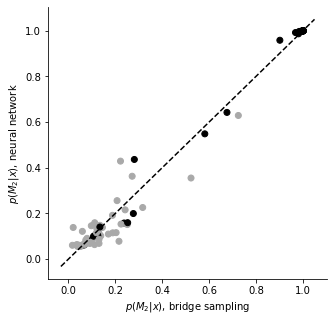

In [45]:
# Posterior probabilities for model 1
# Bridge Sampling vs fixed NN

f, ax = plt.subplots(1, 1, figsize=figsize)
ax.scatter(bridge['m1_prob'], NN_fixed['m1_prob'], c=bridge['true_model'].map(colors))
ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_xlabel('$p$($M_{2}$|$D$), bridge sampling')
#ax.set_ylabel('$p$($M_{2}$|$D$), non-amortized network')
ax.set_xlabel('$p$($M_{2}$|$x$), bridge sampling')
#ax.set_ylabel('$p$($M_{2}$|$x$), non-amortized network')
ax.set_ylabel('$p$($M_{2}$|$x$), neural network')
#ax.set_title('Posterior probability approximation: Hierarchical Network trained with fixed dataset sizes')
#f.savefig('PMPs_TeaP.png', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'Log $BF_{21}$, non-amortized network')

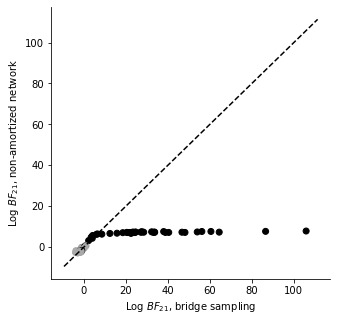

In [17]:
# BFs vs fixed NN

f, ax = plt.subplots(1, 1, figsize=figsize)
ax.scatter(log_bridge_bfs, log_NN_fixed_bfs, c=bridge['true_model'].map(colors))
ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Log $BF_{21}$, bridge sampling ')
ax.set_ylabel('Log $BF_{21}$, non-amortized network')
#ax.set_title('Log Bayes Factor approximation: Hierarchical Network trained with fixed dataset sizes')
#f.savefig('figures/BF_toy.png', dpi=300, bbox_inches='tight')

## Try out different BF approximation visualizations

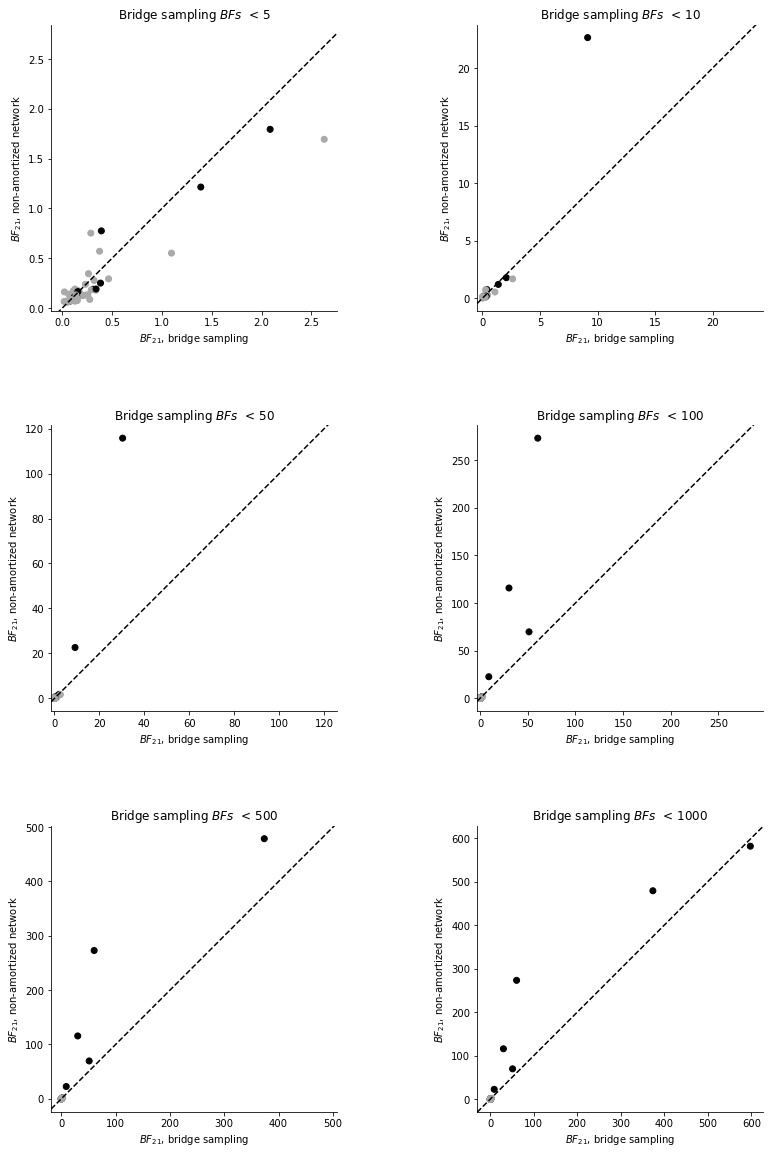

In [18]:
# raw BFs multiple cut-off options

plt.figure(figsize=(14, 20))
plt.subplots_adjust(hspace=0.4)
cutoffs = [5,10,50,100,500,1000]

for n, cutoff in enumerate(cutoffs):

    ax = plt.subplot(3, 2, n+1)

    filter = bridge['bayes_factor']<cutoff

    bridge_bfs = bridge['bayes_factor'][filter]
    NN_fixed_bfs = NN_fixed['bayes_factor'][filter]

    ax.scatter(bridge_bfs, NN_fixed_bfs, c=bridge['true_model'][filter].map(colors))
    plt.axis('square')
    ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('$BF_{21}$, bridge sampling ')
    ax.set_ylabel('$BF_{21}$, non-amortized network')
    ax.set_title('Bridge sampling $BFs$  < {}'.format(cutoff))

# of included datasets: 70


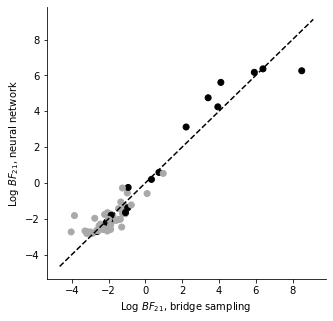

In [41]:
# Log Bfs with filter
filter = bridge['bayes_factor']<100000
print('# of included datasets: {}'.format(sum(filter)))

f, ax = plt.subplots(1, 1, figsize=figsize)
ax.scatter(log_bridge_bfs[filter], log_NN_fixed_bfs[filter], c=bridge['true_model'][filter].map(colors))
ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Log $BF_{21}$, bridge sampling ')
ax.set_ylabel('Log $BF_{21}$, neural network')
#f.savefig('Log_BFs_TeaP.png', dpi=300, bbox_inches='tight')

In [44]:
np.log([10, 100,1000,10000,100000])

array([ 2.30258509,  4.60517019,  6.90775528,  9.21034037, 11.51292546])

In [36]:
np.exp([1,2,3,4,5,6,7,8,9,10])

array([    2.71828183,     7.3890561 ,    20.08553692,    54.59815003,
         148.4131591 ,   403.42879349,  1096.63315843,  2980.95798704,
        8103.08392758, 22026.46579481])

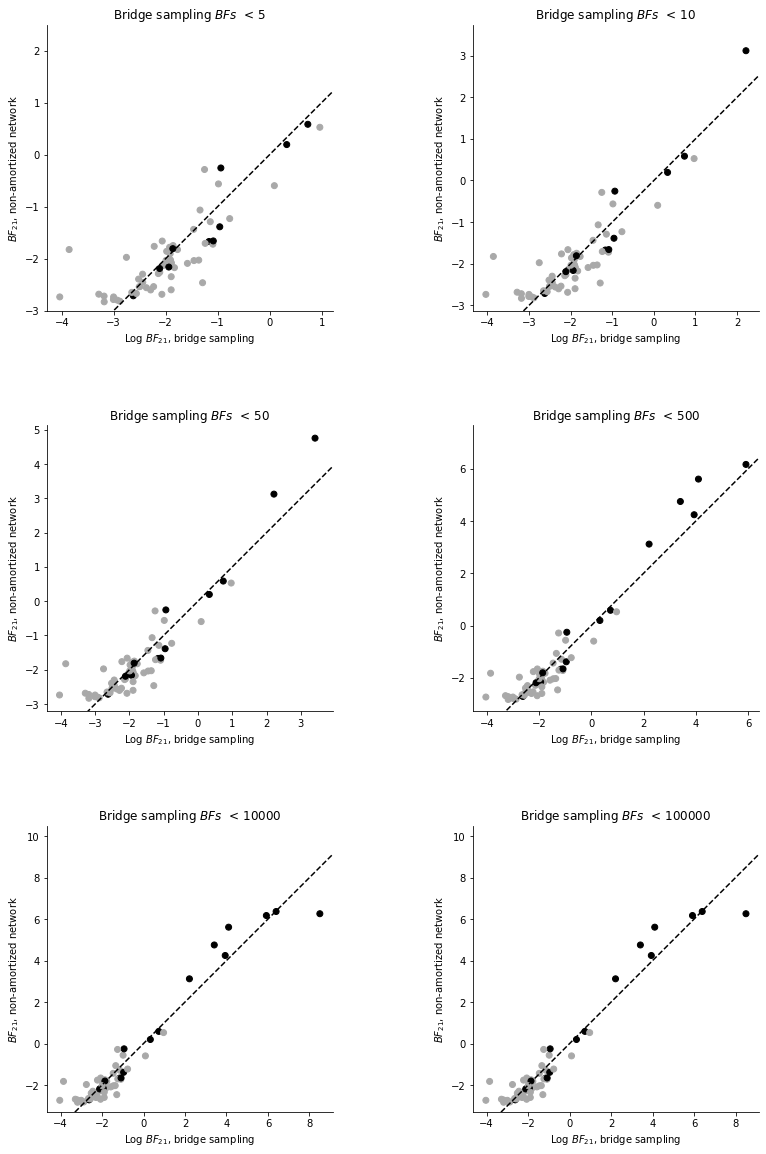

In [20]:
# Log BFs multiple cut-off options

plt.figure(figsize=(14, 20))
plt.subplots_adjust(hspace=0.4)
cutoffs = [5,10,50,500,10000,100000]

for n, cutoff in enumerate(cutoffs):

    ax = plt.subplot(3, 2, n+1)

    filter = bridge['bayes_factor']<cutoff

    ax.scatter(log_bridge_bfs[filter], log_NN_fixed_bfs[filter], c=bridge['true_model'][filter].map(colors))
    plt.axis('square')
    ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Log $BF_{21}$, bridge sampling ')
    ax.set_ylabel('$BF_{21}$, non-amortized network')
    #ax.set_ylabel('Log $BF_{21}$, neural network')
    ax.set_title('Bridge sampling $BFs$  < {}'.format(cutoff))

## BS vs variable NN

Text(0, 0.5, '$p$($M_{2}$|$D$), over $L$ & $N$ amortized network')

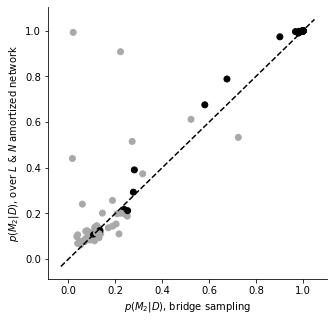

In [21]:
# Posterior probabilities for model 1
# Bridge Sampling vs variable NN

f, ax = plt.subplots(1, 1, figsize=figsize)
ax.scatter(bridge['m1_prob'], NN_variable['m1_prob'], c=bridge['true_model'].map(colors))
ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('$p$($M_{2}$|$D$), bridge sampling')
ax.set_ylabel('$p$($M_{2}$|$D$), over $L$ & $N$ amortized network')
#ax.set_title('Posterior probability approximation: Hierarchical Network trained with variable dataset sizes')
#f.savefig('figures/BF_toy.png', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'Log $BF_{21}$, over $L$ & $N$ amortized network')

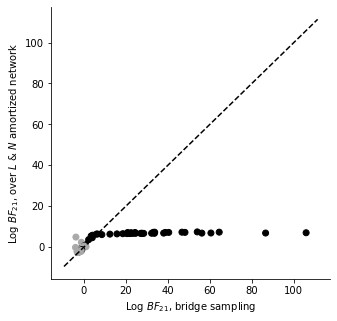

In [22]:
# vs variable NN

f, ax = plt.subplots(1, 1, figsize=figsize)
ax.scatter(log_bridge_bfs, log_NN_variable_bfs, c=bridge['true_model'].map(colors))
ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Log $BF_{21}$, bridge sampling ')
ax.set_ylabel('Log $BF_{21}$, over $L$ & $N$ amortized network')
#ax.set_title('Log Bayes Factor approximation: Hierarchical Network trained with variable dataset sizes')
#f.savefig('figures/BF_toy.png', dpi=300, bbox_inches='tight')

# Plot computation time as function of datasets

In [23]:
# Calculate computation times
bridge_time_min = (bridge['compile_time'] + (bridge['stan_time'] + bridge['bridge_time']).cumsum())/60
NN_fixed_time_min = (NN_fixed['training_time'] + NN_fixed['inference_time'].cumsum())/60
NN_variable_time_min = (NN_variable['training_time'] + NN_variable['inference_time'].cumsum())/60

# Set index to represent datasets
bridge_time_min.index = bridge_time_min.index+1
NN_fixed_time_min.index = NN_fixed_time_min.index+1
NN_variable_time_min.index = NN_variable_time_min.index+1

In [24]:
# Mean computation times per phase
# Bridge Sampling
print('Stan: {}'.format(np.mean(bridge['stan_time'])))
print('Bridge: {}'.format(np.mean(bridge['bridge_time'])))

# NN fixed
print('NN fixed training: {}'.format(np.mean(NN_fixed['training_time'])))
print('NN fixed inference: {}'.format(np.mean(NN_fixed['inference_time'])))

# NN variable
print('NN variable training: {}'.format(np.mean(NN_variable['training_time'])))
print('NN variable inference: {}'.format(np.mean(NN_variable['inference_time'])))

Stan: 42.01806385755539
Bridge: 28.694869680404665
NN fixed training: 667.8317011
NN fixed inference: 0.016648700002406203
NN variable training: 715.3192054999998
NN variable inference: 0.021643799999765102


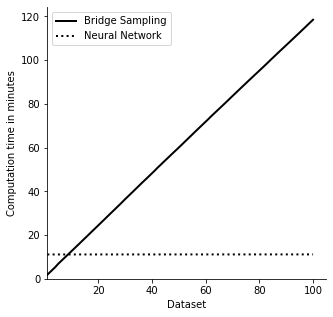

In [29]:
# Plot for all datasets
f, ax = plt.subplots(1, 1, figsize=figsize)
ax.plot(bridge_time_min, label='Bridge Sampling', lw=2, color='black')
ax.plot(NN_fixed_time_min, label='Neural Network', lw=2, linestyle='dotted', color='black')
#ax.plot(bridge_time_min, label='Bridge Sampling computation time', lw=2, color='black')
#ax.plot(NN_fixed_time_min, label='Hierarchical Network fixed computation time', lw=2, linestyle='dotted', color='black')
#ax.plot(NN_variable_time_min, label='Hierarchical Network variable computation time', lw=2, linestyle='dashed', color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Dataset') # add (cumulative)? 
ax.set_ylabel('Computation time in minutes')
ax.set_xlim(xmin=1)
ax.set_ylim(ymin=0)
ax.legend(loc='upper left')
#f.savefig('comp_times_TeaP.png', dpi=300, bbox_inches='tight')

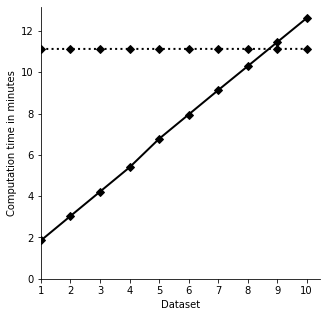

In [29]:
# Plot time for subset of 1:d datasets

d=10

bridge_short = bridge.iloc[:d,:]
NN_fixed_short = NN_fixed.iloc[:d,:]
NN_variable_short = NN_variable.iloc[:d,:]

# Calculate computation times
bridge_time_min = ((bridge_short['compile_time'] + (bridge_short['stan_time'] + bridge_short['bridge_time']).cumsum())/60)
NN_fixed_time_min = ((NN_fixed_short['training_time'] + NN_fixed_short['inference_time'].cumsum())/60)
NN_variable_time_min = ((NN_variable_short['training_time'] + NN_variable_short['inference_time'].cumsum())/60)

# Set index to represent datasets
bridge_time_min.index = bridge_time_min.index+1
NN_fixed_time_min.index = NN_fixed_time_min.index+1
NN_variable_time_min.index = NN_variable_time_min.index+1

# Plot
f, ax = plt.subplots(1, 1, figsize=figsize)
ax.plot(bridge_time_min, label='Bridge Sampling computation time', lw=2, marker='D', color='black')
ax.plot(NN_fixed_time_min, label='Hierarchical Network fixed computation time', lw=2, linestyle='dotted', marker='D', color='black')
#ax.plot(NN_variable_time_min, label='Hierarchical Network variable computation time', lw=2, linestyle='dashed', marker='D', color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Dataset')
ax.set_ylabel('Computation time in minutes')
ax.set_xlim(xmin=1)
ax.set_ylim(ymin=0)
ax.set_xticks(bridge_time_min.index) # only display ticks for each dataset
#ax.legend(loc='upper left')
#f.savefig('figures/BF_N_Toy.png', dpi=300, bbox_inches='tight')